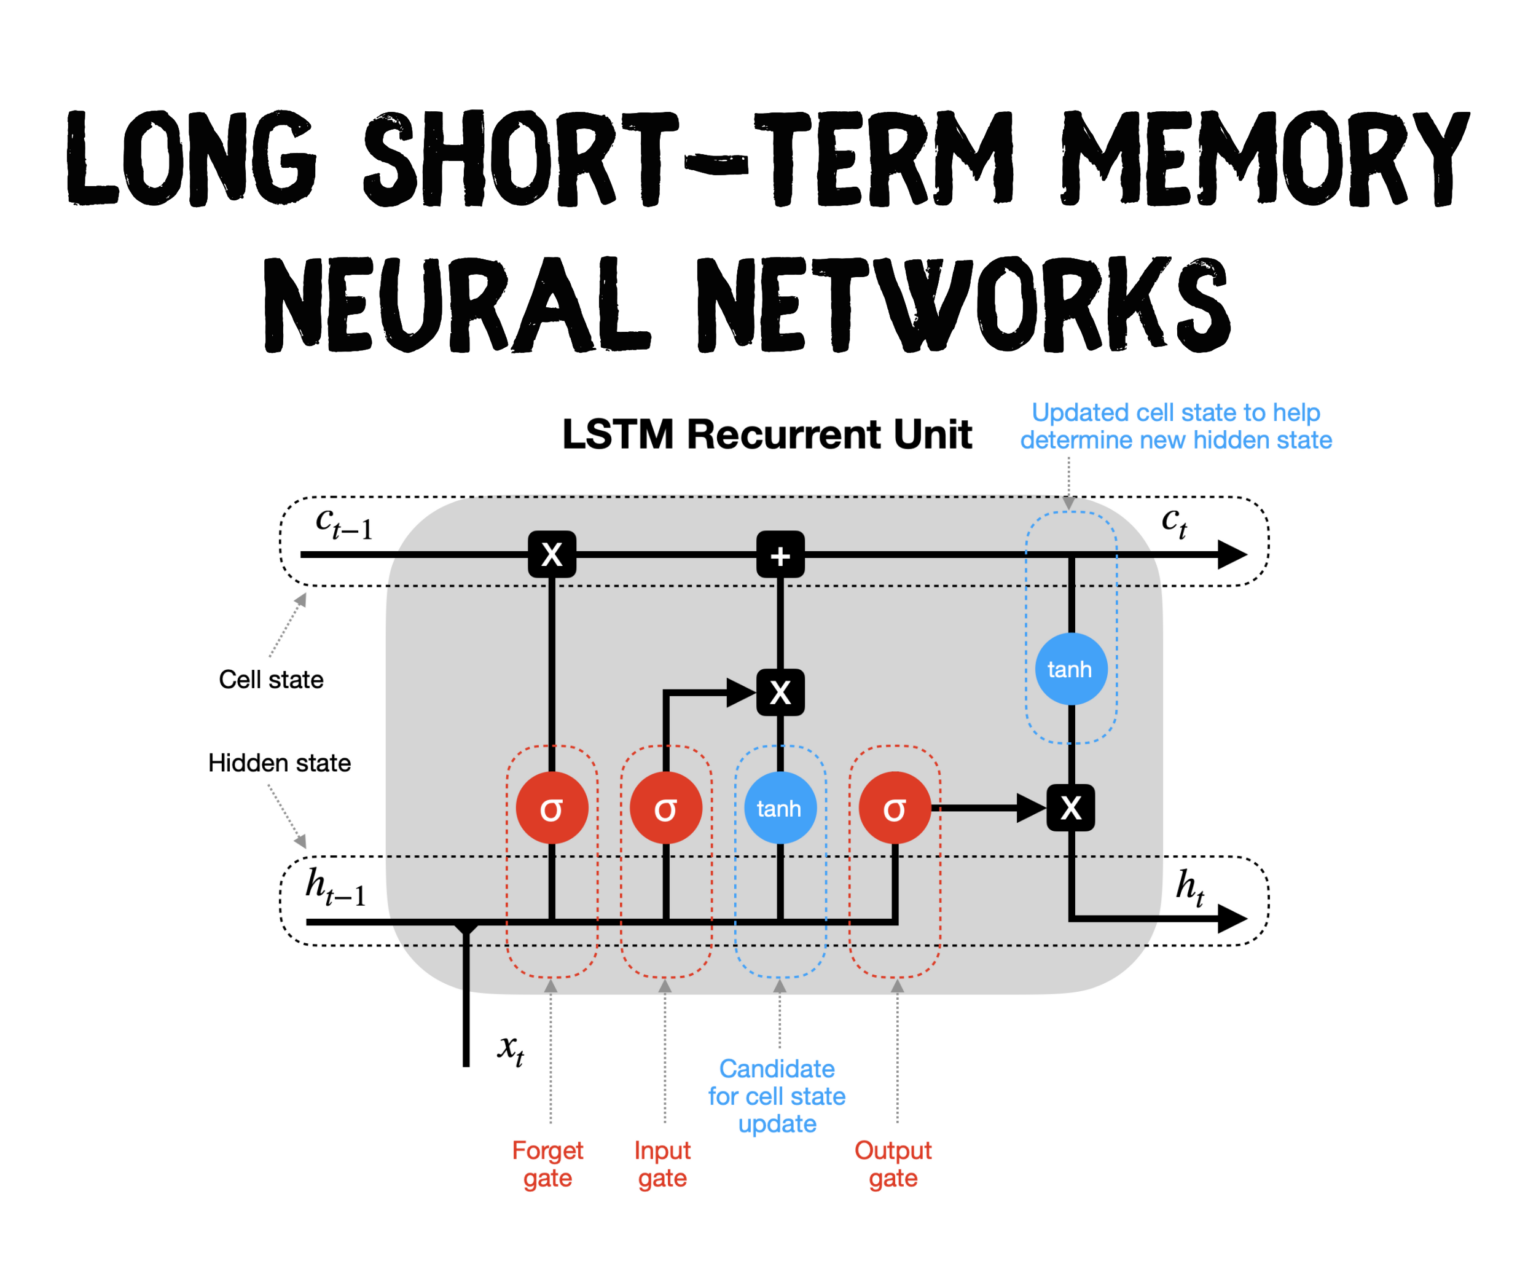!
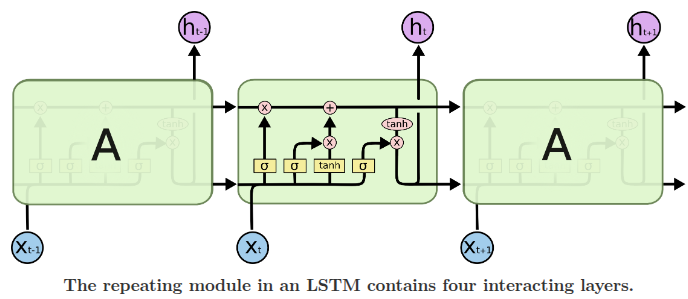

In [1]:
%matplotlib widget

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1' 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import datetime

2025-12-13 00:55:09.588771: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
df = pd.read_csv('daily-min-temperatures.csv', usecols=[1])

# Convertir a float32 (formato preferido por redes neuronales)
data = df.values.astype('float32')
df.head()

,Daily minimum temperatures
0,20.7
1,17.9
2,18.8
3,14.6
4,15.8


In [5]:
datetime_values = [datetime.datetime(1985,1,1)+datetime.timedelta(days=i) 
                   for i in range(len(data))]

In [ ]:
# Normalizamos entre 0 y 1.
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)


# look_back features: datos previos (pasado) 
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# Definimos "look_back" en 30 días 
look_back = 30 # 30 dias previos
X, Y = create_dataset(data_scaled, look_back)

# Reshape para que sea compatible con LSTM [Muestras, Pasos de Tiempo, Características]
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))

# train test
train_size = int(len(X) * 0.80)
test_size = len(X) - train_size
trainX, testX = X[0:train_size], X[train_size:len(X)]
trainY, testY = Y[0:train_size], Y[train_size:len(Y)]

# lstm
model = Sequential()
# Capa oculta 50 neuronas
model.add(LSTM(50, input_shape=(1, look_back)))
# Capa de salida (1 solo valor: la temperatura predicha)
model.add(Dense(1))
# adam optimizer
model.compile(loss='mean_squared_error', optimizer='adam')

print("training model...")
history = model.fit(trainX, trainY, epochs=20, batch_size=32, verbose=1)

# predict: train and test
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invertimos la normalización para volver a grados Celsius reales
trainPredict = scaler.inverse_transform(trainPredict)
trainY_orig = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_orig = scaler.inverse_transform([testY])


# Desplazamiento para predicciones de entrenamiento
trainPredictPlot = np.empty_like(data_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# Desplazamiento para predicciones de prueba (Futuro/Validación)
testPredictPlot = np.empty_like(data_scaled)
testPredictPlot[:, :] = np.nan
# Ajuste de índices para que continúe después del entrenamiento
start_idx = len(trainPredict) + (look_back * 2) + 1

# final : +
end_idx = start_idx + len(testPredict)
if end_idx > len(data_scaled):
    diff = end_idx - len(data_scaled)
    start_idx -= diff
    end_idx -= diff

testPredictPlot[start_idx:end_idx, :] = testPredict
#testPredictPlot[len(trainPredict)+(look_back*2)+1:len(data_scaled)-1, :] = testPredict

In [43]:
trainPredictPlot.shape

(3650, 1)

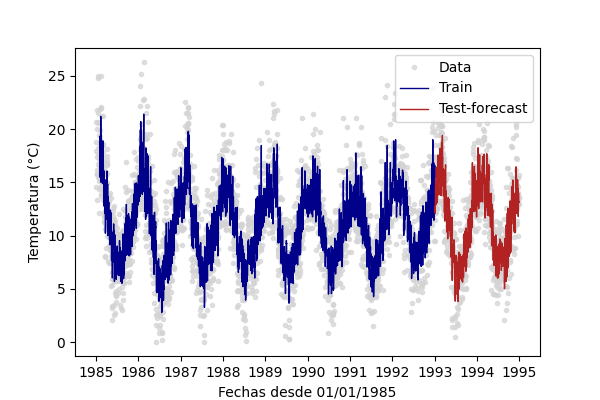

In [20]:
fig = plt.figure(figsize=(6,4))

plt.plot(datetime_values, scaler.inverse_transform(data_scaled),"o",markersize=3, label='Data', color='lightgrey', alpha=0.7)
# Gráfica de cómo aprendió (Entrenamiento)
plt.plot(datetime_values, trainPredictPlot, label='Train', lw=1,color='darkblue')
# Gráfica del pronóstico (Prueba)
plt.plot(datetime_values, testPredictPlot, label='Test-forecast',lw=1, color='firebrick')

#plt.title('Forecast: Temperatura Mínima Diaria usando LSTM')
plt.xlabel('Fechas desde 01/01/1985')
plt.ylabel('Temperatura (°C)')
plt.legend()
#plt.show()



In [19]:
plt.close()

In [21]:
fig.savefig("lstm_forecasting.png", dpi=300)

Text(0.5, 0, 'Epoch')

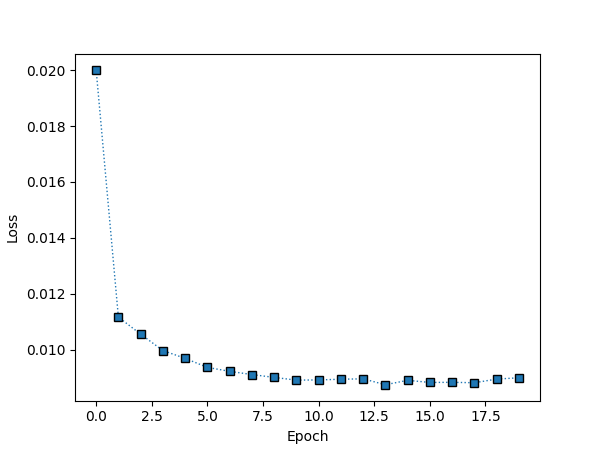

In [28]:
fig = plt.figure(figsize=(6,4.5))
plt.plot(history.history["loss"], "s", ls=":",lw=1,mec="k")
plt.ylabel("Loss")
plt.xlabel("Epoch")

In [29]:
fig.savefig("loss.png", dpi=300)

In [30]:
from sklearn.metrics import mean_squared_error as mse

In [40]:
test_mse=mse(scaler.inverse_transform(data_scaled)[testPredictPlot!=np.nan], testPredictPlot[testPredictPlot!=np.nan])

ValueError: Input contains NaN.

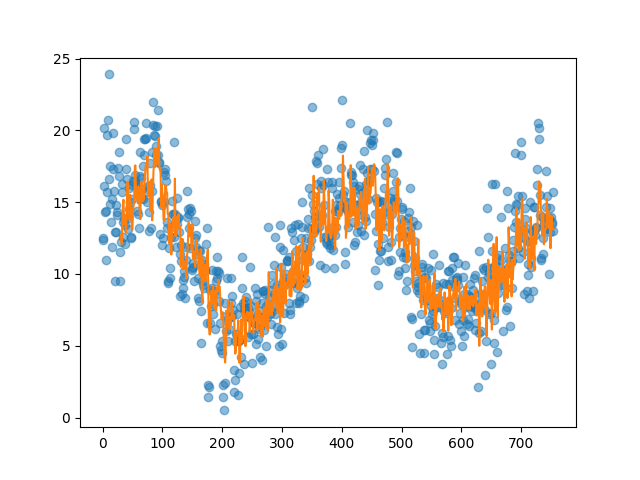

In [35]:
plt.figure()
plt.plot(scaler.inverse_transform(data_scaled)[train_size:], "o", alpha=0.5)

plt.plot(testPredictPlot[train_size:])

In [41]:
testPredictPlot[testPredictPlot!=np.nan]

array([      nan,       nan,       nan, ..., 13.293659, 13.079207,
       13.158126], shape=(3650,), dtype=float32)